# Lab | Data Aggregation and Filtering

In this challenge, we will continue to work with customer data from an insurance company. We will use the dataset called marketing_customer_analysis.csv, which can be found at the following link:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv

This dataset contains information such as customer demographics, policy details, vehicle information, and the customer's response to the last marketing campaign. Our goal is to explore and analyze this data by first performing data cleaning, formatting, and structuring.

In [1]:
import pandas as pd

# URL van de dataset
url = "https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv"

try:
    # Dataset laden
    data = pd.read_csv(url)
  
    
except Exception as e:
    print("Er is een fout opgetreden bij het laden van de dataset:", e)
data.head()

,Unnamed: 0,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,...,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Vehicle Type
0,0,DK49336,Arizona,4809.216960,No,Basic,College,2/18/11,Employed,M,...,0.0,9,Corporate Auto,Corporate L3,Offer3,Agent,292.800000,Four-Door Car,Medsize,NaN
1,1,KX64629,California,2228.525238,No,Basic,College,1/18/11,Unemployed,F,...,0.0,1,Personal Auto,Personal L3,Offer4,Call Center,744.924331,Four-Door Car,Medsize,NaN
2,2,LZ68649,Washington,14947.917300,No,Basic,Bachelor,2/10/11,Employed,M,...,0.0,2,Personal Auto,Personal L3,Offer3,Call Center,480.000000,SUV,Medsize,A
3,3,XL78013,Oregon,22332.439460,Yes,Extended,College,1/11/11,Employed,M,...,0.0,2,Corporate Auto,Corporate L3,Offer2,Branch,484.013411,Four-Door Car,Medsize,A
4,4,QA50777,Oregon,9025.067525,No,Premium,Bachelor,1/17/11,Medical Leave,F,...,NaN,7,Personal Auto,Personal L2,Offer1,Branch,707.925645,Four-Door Car,Medsize,NaN


# 1. Create a new DataFrame that only includes customers who have a total_claim_amount greater than $1,000 and have a response of "Yes" to the last marketing campaign.

In [2]:
filtered_data = data[(data['Total Claim Amount'] > 1000) & (data['Response'] == 'Yes')]
filtered_data



,Unnamed: 0,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,...,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Vehicle Type
189,189,OK31456,California,11009.130490,Yes,Premium,Bachelor,1/24/11,Employed,F,...,0.0,1,Corporate Auto,Corporate L3,Offer2,Agent,1358.400000,Luxury Car,Medsize,NaN
236,236,YJ16163,Oregon,11009.130490,Yes,Premium,Bachelor,1/24/11,Employed,F,...,0.0,1,Special Auto,Special L3,Offer2,Agent,1358.400000,Luxury Car,Medsize,A
419,419,GW43195,Oregon,25807.063000,Yes,Extended,College,2/13/11,Employed,F,...,1.0,2,Personal Auto,Personal L2,Offer1,Branch,1027.200000,Luxury Car,Small,A
442,442,IP94270,Arizona,13736.132500,Yes,Premium,Master,2/13/11,Disabled,F,...,0.0,8,Personal Auto,Personal L2,Offer1,Web,1261.319869,SUV,Medsize,A
587,587,FJ28407,California,5619.689084,Yes,Premium,High School or Below,1/26/11,Unemployed,M,...,0.0,1,Personal Auto,Personal L1,Offer2,Web,1027.000029,SUV,Medsize,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10351,10351,FN44127,Oregon,3508.569533,Yes,Extended,College,1/5/11,Medical Leave,M,...,1.0,1,Personal Auto,Personal L2,Offer2,Branch,1176.278800,Four-Door Car,Small,NaN
10373,10373,XZ64172,Oregon,10963.957230,Yes,Premium,High School or Below,2/8/11,Employed,M,...,0.0,1,Corporate Auto,Corporate L2,Offer1,Agent,1324.800000,Luxury SUV,Medsize,NaN
10487,10487,IX60941,Oregon,3508.569533,Yes,Extended,College,1/5/11,Medical Leave,M,...,1.0,1,Personal Auto,Personal L3,Offer2,Branch,1176.278800,Four-Door Car,Small,NaN
10565,10565,QO62792,Oregon,7840.165778,Yes,Extended,College,1/14/11,Employed,M,...,2.0,1,Personal Auto,Personal L3,Offer2,Agent,1008.000000,NaN,NaN,NaN


2. Using the original Dataframe, analyze the average total_claim_amount by each policy type and gender for customers who have responded "Yes" to the last marketing campaign. Write your conclusions.

In [3]:
filtered_data = data[data['Response'] == 'Yes']

# Group by Policy Type and Gender, then calculate the mean of 'Total Claim Amount'
average_claims = filtered_data.groupby(['Policy Type', 'Gender'])['Total Claim Amount'].mean().reset_index()
average_claims

# While there are slight differences in the average claim amounts between genders in some policy types, they are not substantial. The policy type itself seems to have a more significant influence on the claim amounts than gender.
# 

,Policy Type,Gender,Total Claim Amount
0,Corporate Auto,F,433.738499
1,Corporate Auto,M,408.582459
2,Personal Auto,F,452.965929
3,Personal Auto,M,457.010178
4,Special Auto,F,453.280164
5,Special Auto,M,429.527942


3. Analyze the total number of customers who have policies in each state, and then filter the results to only include states where there are more than 500 customers.

In [4]:
state_customer_count = data.groupby('State').size().reset_index(name='Customer Count')

# Filter the results to include only states with more than 500 customers
filtered_states = state_customer_count[state_customer_count['Customer Count'] > 500]
filtered_states

,State,Customer Count
0,Arizona,1937
1,California,3552
2,Nevada,993
3,Oregon,2909
4,Washington,888


4. Find the maximum, minimum, and median customer lifetime value by education level and gender. Write your conclusions.


In [5]:
lifetime_value_stats = data.groupby(['Education', 'Gender'])['Customer Lifetime Value'].agg(['max', 'min', 'median']).reset_index()
lifetime_value_stats.round()

,Education,Gender,max,min,median
0,Bachelor,F,73226.0,1904.0,5641.0
1,Bachelor,M,67907.0,1898.0,5548.0
2,College,F,61850.0,1899.0,5624.0
3,College,M,61135.0,1918.0,6006.0
4,Doctor,F,44856.0,2396.0,5332.0
5,Doctor,M,32677.0,2268.0,5578.0
6,High School or Below,F,55277.0,2145.0,6040.0
7,High School or Below,M,83325.0,1941.0,6287.0
8,Master,F,51016.0,2418.0,5730.0
9,Master,M,50568.0,2272.0,5579.0


In [12]:
pip install matplotlib
pip install seaborn

SyntaxError: invalid syntax (370712082.py, line 1)

In [13]:
pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/var/folders/pr/ps1lkn7j76xgr01ybr6h_y300000gn/T/ipykernel_92590/2133231566.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Education', y='max', hue='Gender', data=lifetime_value_stats, palette='Set2', ci=None)
/var/folders/pr/ps1lkn7j76xgr01ybr6h_y300000gn/T/ipykernel_92590/2133231566.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Education', y='min', hue='Gender', data=lifetime_value_stats, palette='Set2', ci=None, alpha=0.5)
/var/folders/pr/ps1lkn7j76xgr01ybr6h_y300000gn/T/ipykernel_92590/2133231566.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Education', y='median', hue='Gender', data=lifetime_value_stats, palette='Set2', ci=None, alpha=0.7)


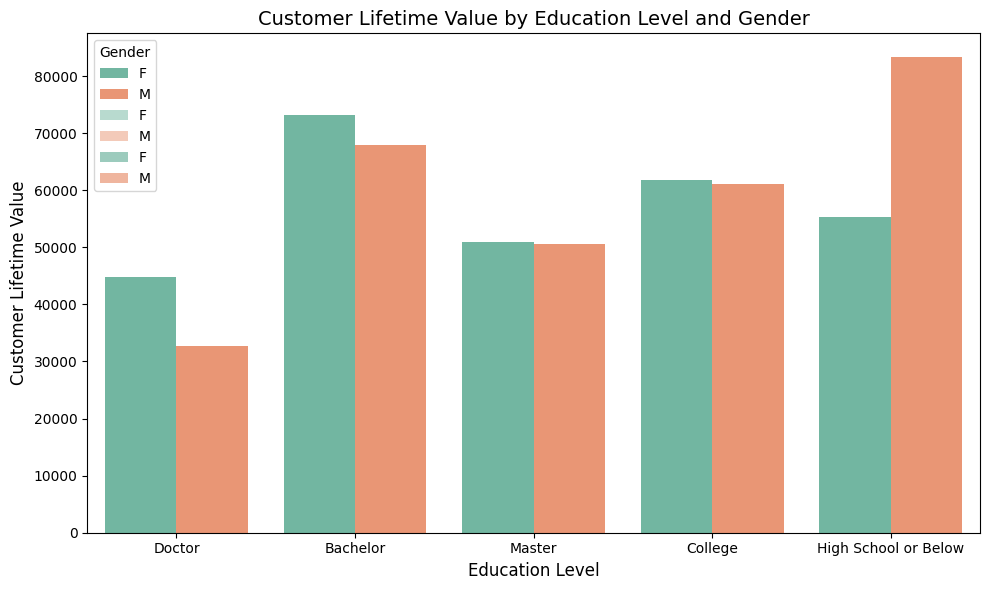

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# URL of the dataset
url = "https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv"

# Load the dataset
data = pd.read_csv(url)

# Group by Education and Gender, then calculate max, min, and median of Customer Lifetime Value
lifetime_value_stats = data.groupby(['Education', 'Gender'])['Customer Lifetime Value'].agg(['max', 'min', 'median']).reset_index()
lifetime_value_stats = lifetime_value_stats.sort_values('median', ascending=True)


# Set up the figure
plt.figure(figsize=(10, 6))

# Create a bar plot for max, min, and median customer lifetime values
sns.barplot(x='Education', y='max', hue='Gender', data=lifetime_value_stats, palette='Set2', ci=None)
sns.barplot(x='Education', y='min', hue='Gender', data=lifetime_value_stats, palette='Set2', ci=None, alpha=0.5)
sns.barplot(x='Education', y='median', hue='Gender', data=lifetime_value_stats, palette='Set2', ci=None, alpha=0.7)

# Add labels and title
plt.title('Customer Lifetime Value by Education Level and Gender', fontsize=14)
plt.xlabel('Education Level', fontsize=12)
plt.ylabel('Customer Lifetime Value', fontsize=12)

# Add a legend
plt.legend(title='Gender', loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


## Bonus

5. The marketing team wants to analyze the number of policies sold by state and month. Present the data in a table where the months are arranged as columns and the states are arranged as rows.

6.  Display a new DataFrame that contains the number of policies sold by month, by state, for the top 3 states with the highest number of policies sold.

*Hint:*
- *To accomplish this, you will first need to group the data by state and month, then count the number of policies sold for each group. Afterwards, you will need to sort the data by the count of policies sold in descending order.*
- *Next, you will select the top 3 states with the highest number of policies sold.*
- *Finally, you will create a new DataFrame that contains the number of policies sold by month for each of the top 3 states.*

7. The marketing team wants to analyze the effect of different marketing channels on the customer response rate.

Hint: You can use melt to unpivot the data and create a table that shows the customer response rate (those who responded "Yes") by marketing channel.

External Resources for Data Filtering: https://towardsdatascience.com/filtering-data-frames-in-pandas-b570b1f834b9

In [ ]:
# your code goes here